# <center> Fitting Time Series Models <center>

In [1]:
#Load data manipulation packages
library(tidyverse)
library(ggplot2)

#Load time series library
library(forecast)
library(tseries)
library(TSA)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.5     
✔ tibble  1.4.2          ✔ dplyr   0.7.5     
✔ tidyr   0.8.1          ✔ stringr 1.3.0     
✔ readr   1.1.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘TSA’

The following object is masked from ‘package:readr’:

    spec

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar



In [2]:
#Read data in
dat = read.csv('bike_sharing_hourly.csv')

In [3]:
#Check data types
str(dat)

'data.frame':	17379 obs. of  17 variables:
 $ instant   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ dteday    : Factor w/ 731 levels "2011-01-01","2011-01-02",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ yr        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ mnth      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ hr        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ weekday   : int  6 6 6 6 6 6 6 6 6 6 ...
 $ workingday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ weathersit: int  1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  0.24 0.22 0.22 0.24 0.24 0.24 0.22 0.2 0.24 0.32 ...
 $ atemp     : num  0.288 0.273 0.273 0.288 0.288 ...
 $ hum       : num  0.81 0.8 0.8 0.75 0.75 0.75 0.8 0.86 0.75 0.76 ...
 $ windspeed : num  0 0 0 0 0 0.0896 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ cnt       : int  16 40 32 13 1 1 2 3 8 14 ...


In [4]:
#Convert date column from type string to type date
dat[,'dteday'] = as.Date(dat[,'dteday'])

In [5]:
#Keep only working days
#dat = dat[dat[,'workingday']==1, ]

In [6]:
head(dat)

instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1


In [7]:
#Create train and test splits
train = dat[dat[,'dteday'] >= '2011-01-01' & dat[,'dteday'] < '2012-10-31', ]
test = dat[dat[,'dteday'] >= '2012-11-01', ]

In [8]:
#Check splits
tail(train)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
15890,15890,2012-10-30,4,1,10,18,0,2,1,3,0.3,0.3030,0.87,0.1343,4,139,143
15891,15891,2012-10-30,4,1,10,19,0,2,1,2,0.5,0.4848,0.68,0.1940,6,109,115
15892,15892,2012-10-30,4,1,10,20,0,2,1,2,0.3,0.2879,0.81,0.1940,5,76,81
15893,15893,2012-10-30,4,1,10,21,0,2,1,2,0.3,0.3182,0.87,0.1045,4,60,64
15894,15894,2012-10-30,4,1,10,22,0,2,1,1,0.3,0.3030,0.81,0.1343,2,64,66
15895,15895,2012-10-30,4,1,10,23,0,2,1,1,0.3,0.3030,0.81,0.1343,3,36,39


To use a dynamic harmonic regression model, the dependant and independent variable must be stationary. I use the ADF test to check for stationarity. In order

## Identifying seasonal periods

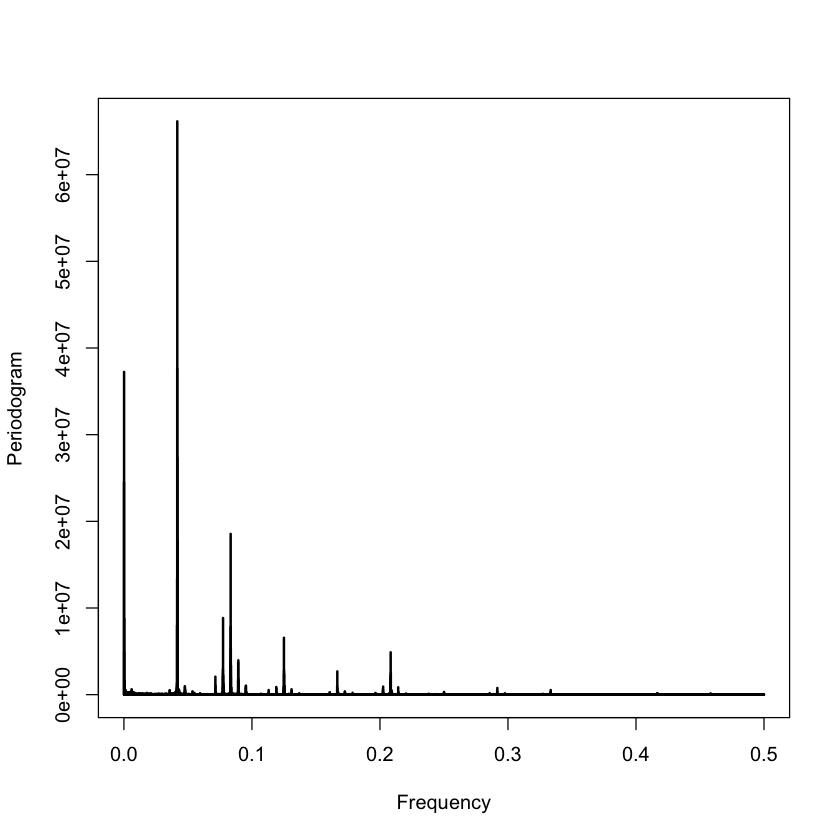

In [9]:
#Create periodogram to identify multiple seasonalities
PGram = TSA::periodogram(train[,'cnt'])

In [10]:
PGramAsDataFrame = data.frame(freq=PGram$freq, spec=PGram$spec)
order = PGramAsDataFrame[order(-PGramAsDataFrame$spec),]
top2 = head(order, 4)
top2

,freq,spec
667,0.0416875,66154210
666,0.0416250,37587564
2,0.0001250,37239772
668,0.0417500,27342270


In [11]:
seasonal_1 = 1/top2[2,1]
seasonal_2 = 1/top2[1,1]
seasonal_1
seasonal_2

[1] 24.02402

[1] 23.98801

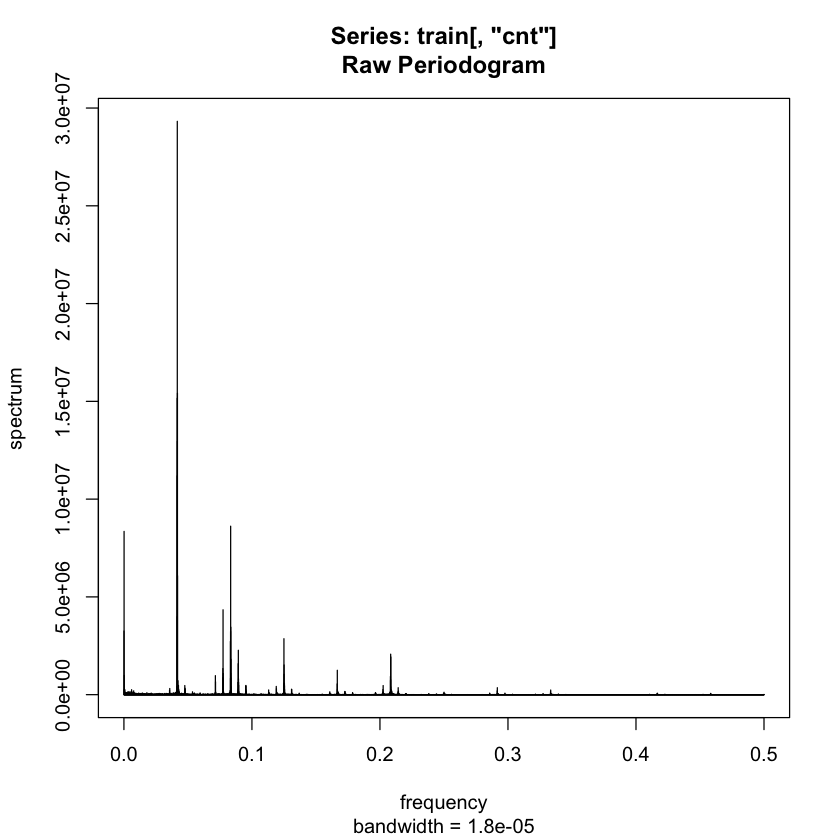

In [12]:
x = spec.pgram(train[,'cnt'], log='no', type='h')

In [13]:
#Get values of largest spikes
sorted_spec = sort(x$spec,decreasing = TRUE)

#Get frequency of periods as follows
n_obs = length(train[,'cnt'])

#Strong seasonal period
1/x$freq[which(x$spec == max(x$spec))]
n_obs / which(x$spec == max(x$spec))

#Identify potential frequencies using periodogram
periods = c()
for (i in 1:30){
    periods[i] = 1 / x$freq[which(x$spec == sorted_spec[i])]
}

print(periods %>% round(1) %>% unique())
#Second strongest
#n_obs / which(x$spec == sorted_spec[2])
#3rd strongest
#n_obs / which(x$spec == sorted_spec[3])

[1] 23.98801

[1] 23.83058

 [1]    24.0    23.9    24.1    12.0  8000.0    12.9 16000.0     8.0    11.2
[10]     4.8     6.0  4000.0    14.0


To identify periodicities in our data, we use a periodogram. The large spikes and their corresponding frequencies help us identify seasonal periods in our data. The spikes occur at low level periods, namely 4, 8, 12 and 24. Additionally we also find evidence of annual (8640 obs) and quarterly(2,880 obs) seasonality. However due to the small sample size, these seasonalities are weak at best.

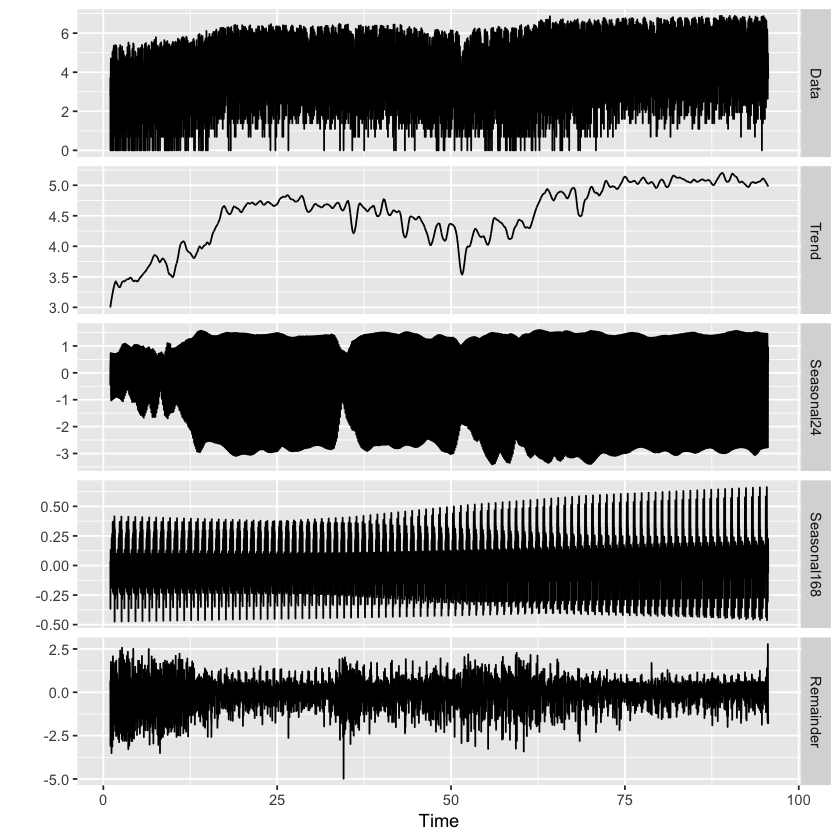

In [23]:
#Decompose hourly bike counts accounting for multiple seasonalities
s1 = 24 #Daily seasonality
#s2 = 12 #Half daily seasonality
#s3 = 8#24*7*4.34 #Every four hours
#s4 = 4
s5 = 24*7 #Weekly seasonality
#s6 = 24*(365/4) #quarterly seasonality
#s7 = 24*330#(365/12) #Monthly seasonality
seasonal_periods = c(s1,s5)#,s3,s4,s5)

count_ts = msts(log(train[,'cnt']), seasonal.periods = seasonal_periods)

#Use multiple seasonal decomposition
count_ts %>% mstl(s.window = seasonal_periods) %>% autoplot()

## Are Bike counts stationary?

In [24]:
#Check if ride counts is stationary
tseries::adf.test(diff(train[,'cnt']))
tseries::kpss.test(diff(train[,'cnt']), null='Trend')

Warning message in tseries::adf.test(diff(train[, "cnt"])):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  diff(train[, "cnt"])
Dickey-Fuller = -54.749, Lag order = 25, p-value = 0.01
alternative hypothesis: stationary


Warning message in tseries::kpss.test(diff(train[, "cnt"]), null = "Trend"):
“p-value greater than printed p-value”


	KPSS Test for Trend Stationarity

data:  diff(train[, "cnt"])
KPSS Trend = 0.00052041, Truncation lag parameter = 14, p-value = 0.1


Both tests suggest that a first difference is sufficient to make counts trend or level stationary.

## TBATS Model

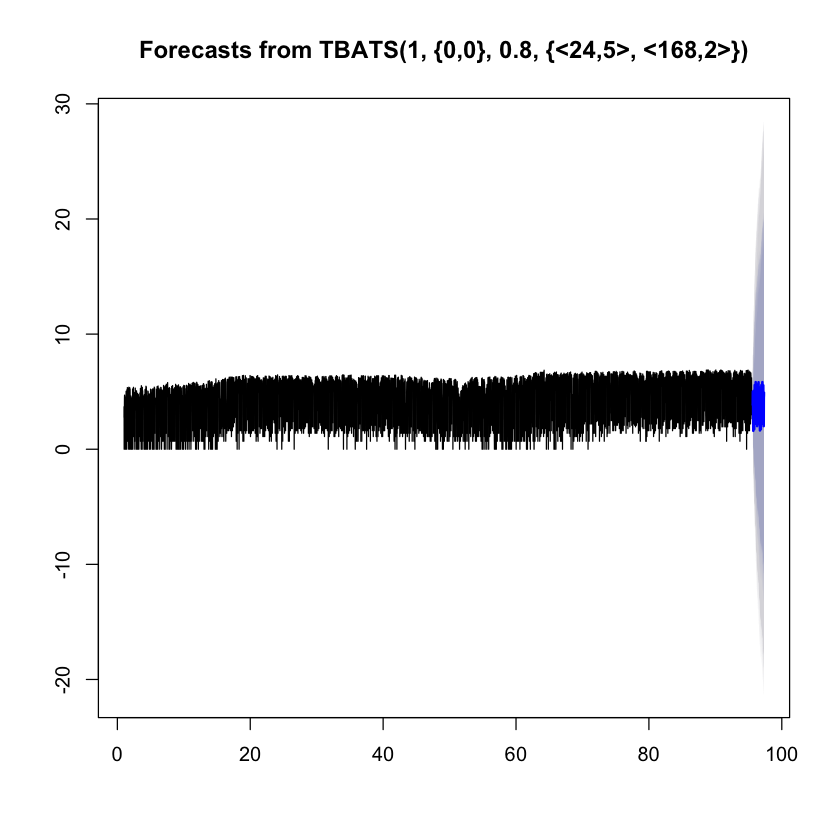

In [25]:
tbats.model = tbats(count_ts,use.parallel = TRUE)
n_preds = 24*12
tbats.forecast = forecast(tbats.model,h=n_preds)
plot(tbats.forecast)

In [26]:
tbats.forecast['mean']

$mean
Multi-Seasonal Time Series:
Start: 95 104
Seasonal Periods: 24 168
Data:
  [1] 3.855225 3.896868 3.996504 4.416829 4.906340 5.013246 4.694090 4.339826
  [9] 4.202277 4.072366 3.658510 3.062721 2.630523 2.426060 2.168829 1.761861
 [17] 1.598427 2.103517 3.100965 3.923450 4.170393 4.103991 4.181746 4.427521
 [25] 4.515045 4.363743 4.315792 4.625082 5.033031 5.082150 4.724388 4.346986
 [33] 4.198762 4.068196 3.661711 3.079687 2.666307 2.484599 2.253136 1.874169
 [41] 1.740314 2.275998 3.304574 4.158305 4.436249 4.400285 4.507634 4.781911
 [49] 4.896623 4.771000 4.747045 5.078496 5.506634 5.573856 5.232009 4.868252
 [57] 4.731334 4.609682 4.209684 3.631695 3.219890 3.037304 2.802527 2.417846
 [65] 2.275921 2.801239 3.817224 4.656222 4.917387 4.862700 4.949498 5.201520
 [73] 5.292406 5.141526 5.091032 5.394814 5.794313 5.832088 5.460154 5.065837
 [81] 4.898059 4.745418 4.314471 3.705743 3.263578 3.051173 2.787279 2.374337
 [89] 2.205157 2.704367 3.695528 4.511110 4.750386 4.675445 4.7

In [29]:
str(tbats.forecast$mean)

 Time-Series [1:288] from 95.6 to 97.3: 3.86 3.9 4 4.42 4.91 ...
 - attr(*, "msts")= num [1:2] 24 168



Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



,ME,RMSE,MAE,MPE,MAPE
Test set,235.6395,304.328,235.7057,88.03914,90.25429


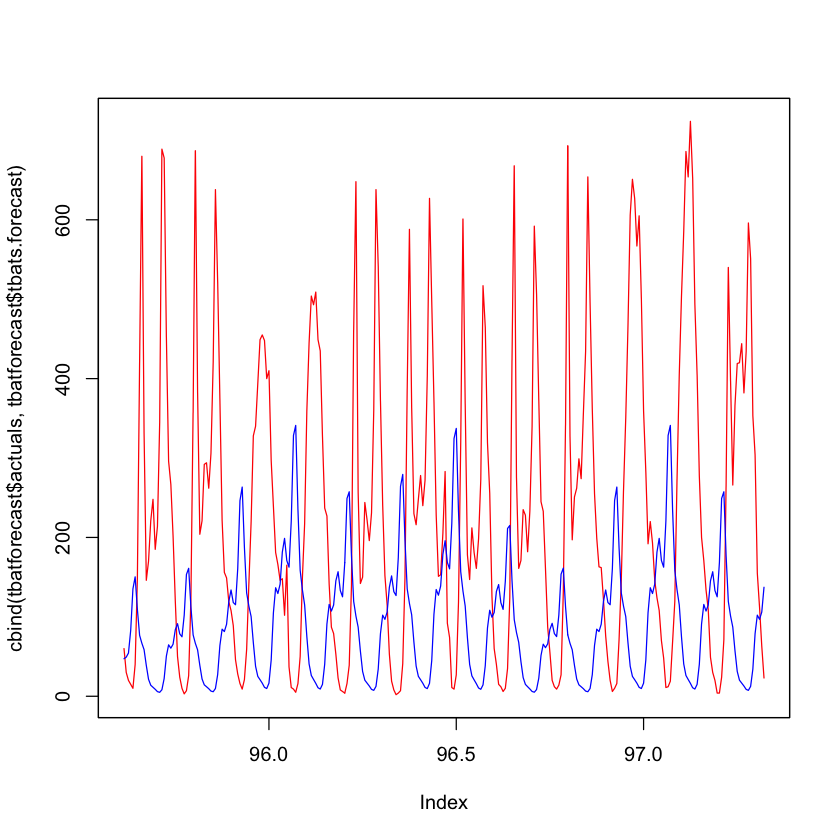

In [30]:
#Create dataframe of actual and foretest$values
actuals = test[,'cnt'][1:n_preds]

#Create dataframe to use for plotting purposes
tbatforecast = data.frame(actuals, exp(tbats.forecast$mean))
colnames(tbatforecast) = c("actuals","tbats.forecast")

#Visualize forecast error
library(zoo)
plot.zoo(cbind(tbatforecast$actuals, tbatforecast$tbats.forecast), 
         plot.type = "single", 
         col = c("red", "blue"))

#Compute errors
accuracy(tbats.forecast$mean, actuals)

## Regression with ARIMA Errors

Here we try and fit a dynamic harmonic regression model. The idea is that we use fourier terms to capture high frequency seasonalities. By varying the number of fourier terms used (i.e. pairs of sine and cosine), we can control the degree of smoothness. In this way, we can also include additional regressors. The result is a regression model with ARIMA errors (ARMA if we don't difference variables to make them stationary). 

In [ ]:
seasonal_periods

In [ ]:
#Convert train and test set to msts objects
train = msts(train, seasonal.periods = seasonal_periods)
test = msts(test, seasonal.periods = seasonal_periods)

In [ ]:
#Creating a deterministic trend
det_trend = seq_along(count_ts)
#plot(count_ts/det_trend)

In [ ]:
#Fit a model to difference counts
stationary_counts = diff(train[,'cnt'])

In [ ]:
#Create fourier terms to capture seasonality
n_harmonics = c(10,5,5)#c(1,1,5,5)
seasonal_fourier = fourier(train[,'cnt'], K=n_harmonics)

In [ ]:
#Fit a regression model with ARIMA errors
xreg = cbind(seasonality=seasonal_fourier)
#              WindSpeed = train[, "windspeed"],
#               RealFeel_Temp = (train[, "atemp"]),
#               holiday = train[, "holiday"])

In [ ]:
#Look at regressors
head(xreg)

In [ ]:
#Fit model
( fit = auto.arima(y=train[,'cnt'],seasonal=FALSE, xreg=xreg) )

In [ ]:
fit %>%
  forecast(xreg=fourier(train[,'cnt'], K=n_harmonics, h=24*12)) %>%
  autoplot(include=24*100)

In [ ]:
#Forecast accuracy
n_preds = 24*12
dyn_harm_reg = forecast(fit,xreg=fourier(train[,'cnt'], K=n_harmonics, h=n_preds))
obs_count = test[,'cnt'][1:n_preds]

accuracy(dyn_harm_reg$mean, obs_count)

In [ ]:
#Check residuals of fitted model
cbind("Regression Errors" = residuals(fit, type="regression"),
      "ARIMA errors" = residuals(fit, type="innovation")) %>% 
autoplot(facets=TRUE)

In [ ]:
#Check if residuals are uncorrelated/normally distributed
checkresiduals(fit)

The ACF plot displays a sinosuidal shape. Furthermore the lags are all well outside the confidence bounds. It would seem that our model is not capturing all of the seasonality. Furthermore our residuals do not look stationary.

In [ ]:
?kpss.test()

In [ ]:
#Check if residuals are stationary
kpss.test(fit$residuals, null = 'Trend')

acf(fit$residuals)